In [1]:
# !pip install optuna
# !pip install shap

In [2]:
# --- NOTEBOOK 08: HYPERPARAMETER TUNING ---
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna  
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import logging
import gc

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class Config:
    INPUT_PATH = 'train_full_merged.parquet'
    SEED = 42
    N_FOLDS = 5
    # We reduce rows for Tuning to speed it up (Optional but recommended)
    # If you have a powerful machine, set this to False
    SUBSAMPLE_FOR_TUNING = True 
    SUBSAMPLE_SIZE = 50000 

logger.info("Notebook 08 Initialized.")

2026-01-22 19:39:31,899 - INFO - Notebook 08 Initialized.


In [3]:
def objective(trial, X, y):
    # 1. Define the Search Space
    # Optuna will pick a value from these ranges
    param_grid = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_estimators': 2000,
        'learning_rate': 0.05, # Fixed for tuning speed (we lower it for final run)
        'verbosity': -1,
        'random_state': Config.SEED,
        'n_jobs': 4,
        
        # TUNING PARAMETERS
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    }
    
    # 2. Cross Validation (3-Fold is enough for tuning, 5 is better but slower)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=Config.SEED)
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        # Train with Early Stopping
        model = lgb.LGBMClassifier(**param_grid)
        callbacks = [lgb.early_stopping(stopping_rounds=50, verbose=False)]
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            callbacks=callbacks
        )
        
        preds = model.predict_proba(X_val)[:, 1]
        scores.append(roc_auc_score(y_val, preds))
    
    # Return Mean AUC
    return np.mean(scores)

def run_tuning():
    logger.info("Loading Data...")
    df = pd.read_parquet(Config.INPUT_PATH)
    
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
    
    # Subsample for Speed?
    if Config.SUBSAMPLE_FOR_TUNING:
        from sklearn.model_selection import train_test_split
        X, _, y, _ = train_test_split(X, y, train_size=Config.SUBSAMPLE_SIZE, stratify=y, random_state=Config.SEED)
        logger.info(f"Tuning on subsample: {X.shape}")
        
    logger.info("Starting Optuna Study...")
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X, y), n_trials=30) # Run 30 trials
    
    logger.info("--- BEST PARAMETERS ---")
    logger.info(study.best_params)
    logger.info(f"Best CV Score: {study.best_value}")
    
    return study.best_params

# Execute Tuning
# best_params = run_tuning()

In [4]:
best_params = run_tuning()
best_params

2026-01-22 19:39:46,494 - INFO - Loading Data...
2026-01-22 19:39:50,941 - INFO - Tuning on subsample: (50000, 315)
2026-01-22 19:39:50,943 - INFO - Starting Optuna Study...
[I 2026-01-22 19:39:50,944] A new study created in memory with name: no-name-0d5d7592-c0db-4cbf-939d-22dc8b095fda
[I 2026-01-22 19:41:20,541] Trial 0 finished with value: 0.7684863277739039 and parameters: {'num_leaves': 62, 'max_depth': 3, 'min_child_samples': 79, 'reg_alpha': 1.581767051237067, 'reg_lambda': 0.28825947015790576, 'colsample_bytree': 0.9431131133570979, 'subsample': 0.9048822322155701}. Best is trial 0 with value: 0.7684863277739039.
[I 2026-01-22 19:44:16,184] Trial 1 finished with value: 0.7682271758954352 and parameters: {'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 28, 'reg_alpha': 9.119040772400908, 'reg_lambda': 0.27286297996068737, 'colsample_bytree': 0.6559121726466606, 'subsample': 0.8920708672729065}. Best is trial 0 with value: 0.7684863277739039.
[I 2026-01-22 19:45:30,981] Tr

{'num_leaves': 56,
 'max_depth': 3,
 'min_child_samples': 90,
 'reg_alpha': 2.837451550017555,
 'reg_lambda': 6.287635041968818,
 'colsample_bytree': 0.7015261826475634,
 'subsample': 0.7215505327891225}

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features with the mean of the target variable.
    Smoothing is applied to prevent overfitting on rare categories.
    """
    def __init__(self, cols=None, smoothing=10):
        self.cols = cols
        self.smoothing = smoothing
        self.maps = {}
        self.global_mean = 0
        
    def fit(self, X, y):
        self.global_mean = y.mean()
        
        for col in self.cols:
            # Calculate stats
            stats = y.groupby(X[col]).agg(['count', 'mean'])
            counts = stats['count']
            means = stats['mean']
            
            # Smooth the mean
            # (count * mean + smoothing * global_mean) / (count + smoothing)
            smooth = (counts * means + self.smoothing * self.global_mean) / (counts + self.smoothing)
            self.maps[col] = smooth
            
        return self

    def transform(self, X):
        X_out = X.copy()
        for col in self.cols:
            # Map values, fill unknown with global mean
            X_out[col] = X_out[col].map(self.maps[col]).fillna(self.global_mean)
        return X_out

In [12]:
def run_final_model(best_params):
    logger.info("--- STARTING FINAL TRAINING ---")
    
    df = pd.read_parquet(Config.INPUT_PATH)
    X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
    y = df['TARGET']
    
    # Identify Categoricals
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.SEED)
    scores = []
    
    # Storage for the last fold's artifacts (for SHAP)
    last_model = None
    last_X_val_encoded = None
    
    # Update params
    final_params = best_params.copy()
    final_params['learning_rate'] = 0.01 
    final_params['n_estimators'] = 10000 
    final_params['objective'] = 'binary'
    final_params['metric'] = 'auc'
    
    for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        # 1. APPLY TARGET ENCODING
        encoder = TargetEncoder(cols=cat_cols)
        X_train_enc = encoder.fit_transform(X_train, y_train)
        X_val_enc = encoder.transform(X_val)
        
        # 2. TRAIN
        model = lgb.LGBMClassifier(**final_params)
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=200, verbose=False),
            lgb.log_evaluation(period=0) # Silence logs for cleanliness
        ]
        
        model.fit(
            X_train_enc, y_train,
            eval_set=[(X_val_enc, y_val)],
            eval_metric='auc',
            callbacks=callbacks
        )
        
        score = roc_auc_score(y_val, model.predict_proba(X_val_enc)[:, 1])
        scores.append(score)
        logger.info(f"Fold {fold+1} AUC: {score:.4f}")
        
        # SAVE ARTIFACTS FROM THE LAST FOLD
        if fold == 4: # The final fold
            last_model = model
            last_X_val_encoded = X_val_enc
        
    logger.info(f"Final Mean AUC: {np.mean(scores):.4f}")
    
    # CRITICAL FIX: Return the model to the global scope
    return last_model, last_X_val_encoded

# Execute and CAPTURE the model this time
final_model, X_val_shap = run_final_model(best_params)

2026-01-22 23:11:54,647 - INFO - --- STARTING FINAL TRAINING (With Export) ---
2026-01-22 23:16:27,492 - INFO - Fold 1 AUC: 0.7828
2026-01-22 23:21:31,983 - INFO - Fold 2 AUC: 0.7933
2026-01-22 23:25:52,049 - INFO - Fold 3 AUC: 0.7826
2026-01-22 23:30:42,265 - INFO - Fold 4 AUC: 0.7908
2026-01-22 23:35:48,970 - INFO - Fold 5 AUC: 0.7851
2026-01-22 23:35:48,972 - INFO - Final Mean AUC: 0.7869


2026-01-23 00:06:23,883 - INFO - Calculating SHAP values for 50000 samples...
C:\Users\gopala.v.lv\AppData\Roaming\Python\Python313\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
2026-01-23 00:07:38,766 - INFO - SHAP Calculation Complete. Generating Plots...


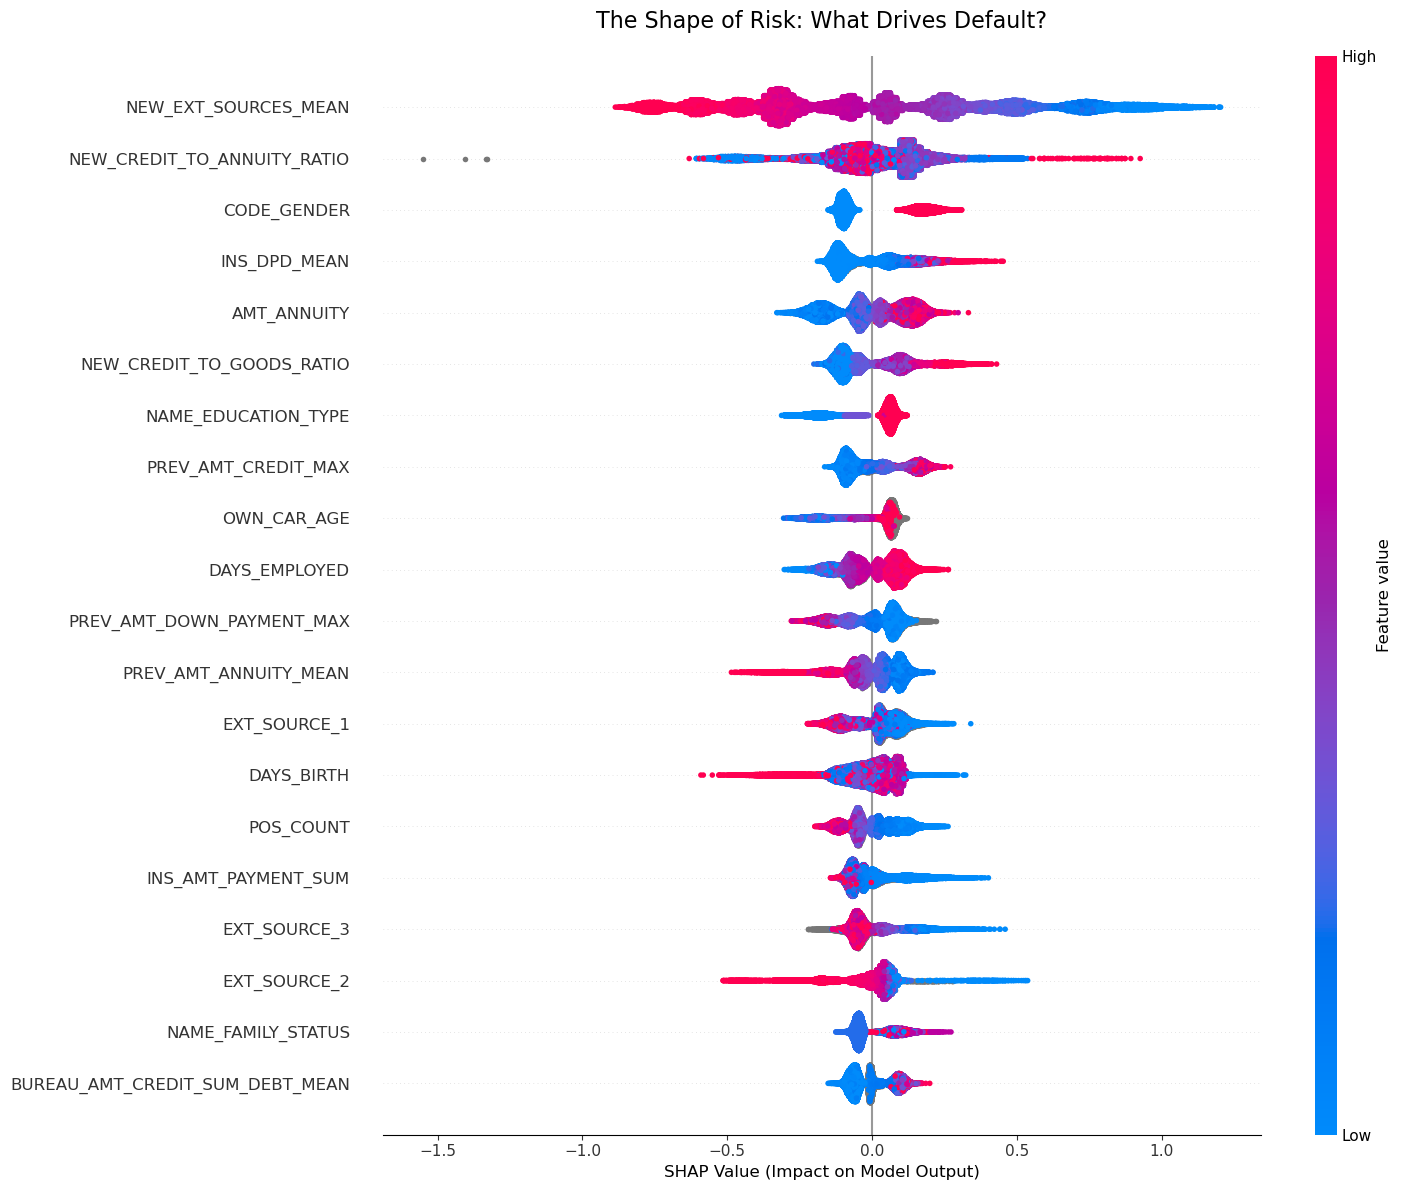

--- Deep Dive on Customer Index 15914 ---
Predicted Risk: 85.67%


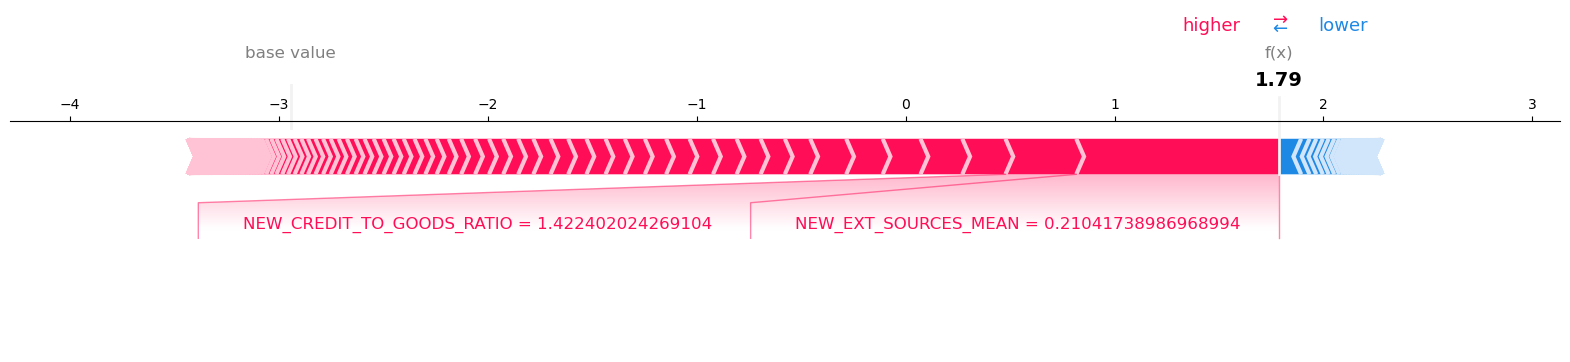

In [14]:
# --- SHAP ANALYSIS ---
import shap

# 1. Performance Optimization
# SHAP is expensive. We don't need 60k rows to see the pattern. 
# 10,000 samples give us 99% of the interpretability in 1% of the time.
shap_sample = X_val_shap.sample(n=50000, random_state=Config.SEED)

logger.info(f"Calculating SHAP values for {shap_sample.shape[0]} samples...")

# 2. Create Explainer
# TreeExplainer is optimized for GBDT models (LightGBM/XGBoost)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(shap_sample)

# LightGBM binary classification returns a list of two arrays [Class 0, Class 1].
# We want Class 1 (Default Probability).
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

logger.info("SHAP Calculation Complete. Generating Plots...")

# 3. GLOBAL INTERPRETABILITY (The Beeswarm)
plt.figure(figsize=(15, 12))
plt.title("The Shape of Risk: What Drives Default?", fontsize=16, pad=20)

shap.summary_plot(
    shap_values_class1, 
    shap_sample, 
    max_display=20, # Show top 20 features
    show=False,
    plot_size=(15, 12)
)

# Customizing for Executive Presentation
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(50) 
plt.xlabel("SHAP Value (Impact on Model Output)", fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('shap_summary_beeswarm.png', dpi=300)
plt.show()

# 4. LOCAL INTERPRETABILITY (The "Alex" Analysis)
# Find the riskiest person
riskiest_idx = np.argmax(final_model.predict_proba(shap_sample)[:, 1])
print(f"--- Deep Dive on Customer Index {riskiest_idx} ---")
print(f"Predicted Risk: {final_model.predict_proba(shap_sample)[riskiest_idx, 1]:.2%}")

# --- ROBUST BASE VALUE EXTRACTION ---
# Check if expected_value is a list/array or a single number
base_value = explainer.expected_value
if isinstance(base_value, (list, np.ndarray)):
    # If it's a list (e.g., [value_class0, value_class1]), take class 1
    base_value = base_value[1]
else:
    # If it's a scalar, it's already the raw score (usually Log-Odds)
    base_value = base_value

# Generate Plot
shap.force_plot(
    base_value,  # Use the safe variable
    shap_values_class1[riskiest_idx,:], # Their specific SHAP values
    shap_sample.iloc[riskiest_idx,:], # Their feature values
    matplotlib=True,
    show=False
)
plt.savefig('shap_force_plot_riskiest.png', dpi=300, bbox_inches='tight')
plt.show()